<img src='./notes/LSA - 1.png'>

In [99]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

## STEP 1 : Raw Text Data

In [1]:
data = [
    'the quick brown fox',
    'the slow brown dog',
    'the quick red dog',
    'the lazy yellow fox'
]

## Document Term Matrix
* ### We can use `CountVectorizer` to create document term matrix

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

dtm = vectorizer.fit_transform(data)
dtm.todense()

matrix([[1, 0, 1, 0, 1, 0, 0, 1, 0],
        [1, 1, 0, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 1, 1, 0, 1, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1]], dtype=int64)

## Singular Value Decomposition
* The word truncated refers to fact that we are not going to get back as many vectors as we started with.
* This process transforms the original data into topic encoded data 

In [3]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2)

encoding = svd.fit_transform(dtm)

## Topic encoded data 

In [4]:
encoding

array([[ 1.69490493,  0.29952405],
       [ 1.51585111, -0.76911037],
       [ 1.51585111, -0.76911037],
       [ 1.26618606,  1.44058513]])

* Each row is indexed by its original text value
* The data now consists of two columns of data, representing each of the two topics used to encode the data
* This value of 2 was passed as an argument to `TruncatedSVD`

In [5]:
import pandas as pd

encoding_df = pd.DataFrame(data=encoding, columns=['Topic-1', 'Topic-2'])
encoding_df['Data'] = data
encoding_df[['Data','Topic-1', 'Topic-2']]

,Data,Topic-1,Topic-2
0,the quick brown fox,1.694905,0.299524
1,the slow brown dog,1.515851,-0.769110
2,the quick red dog,1.515851,-0.769110
3,the lazy yellow fox,1.266186,1.440585


* All four text are strong in topic-1
* In topic-2 we have negative values for text at index {1,2} 
* If we look at the data its very intutive 
    *  text at index {1,2} talks about dog
    *  text at index {0,3} talks about fox


## Lets understand the topics further


#### `vectorizer.get_feature_names_out()` will output tall the words in our vocabulary

In [6]:
vocab = vectorizer.get_feature_names_out()

### The Encoding matrix
The Encoding matrix is composed of `components_` stored as an attribute of a fit TruncatedSVD.
* We can examine this matrix to gain an understanding of the topics latent to the text

In [7]:
svd.components_

array([[ 0.3539373 ,  0.33419932,  0.3264155 ,  0.13957787,  0.3539373 ,
         0.16709966,  0.16709966,  0.66061483,  0.13957787],
       [-0.14025617, -0.4594362 ,  0.5197363 ,  0.43027437, -0.14025617,
        -0.2297181 , -0.2297181 ,  0.0603001 ,  0.43027437]])

In [8]:
encoding_matix = pd.DataFrame(data = svd.components_, index=['Topic-1', 'Topic-2'], columns=vocab).T
encoding_matix

,Topic-1,Topic-2
brown,0.353937,-0.140256
dog,0.334199,-0.459436
fox,0.326416,0.519736
lazy,0.139578,0.430274
quick,0.353937,-0.140256
red,0.167100,-0.229718
slow,0.167100,-0.229718
the,0.660615,0.060300
yellow,0.139578,0.430274


## Interpret The Encoding Matrix

#### What are the top words for each topic ?
#### What dimension in word space explain most of the variance in data?

* To analyse this we need to look at the absolute value of the expression of each word in the topic 
* The word that has a strong negative representation is as important as a word that has a strong positive representation

In [12]:
encoding_matix['Abs-topic-1'] = np.abs(encoding_matix['Topic-1'])

encoding_matix.sort_values(by='Abs-topic-1', ascending=False)

,Topic-1,Topic-2,Abs-topic-1
the,0.660615,0.060300,0.660615
brown,0.353937,-0.140256,0.353937
quick,0.353937,-0.140256,0.353937
dog,0.334199,-0.459436,0.334199
fox,0.326416,0.519736,0.326416
slow,0.167100,-0.229718,0.167100
red,0.167100,-0.229718,0.167100
lazy,0.139578,0.430274,0.139578
yellow,0.139578,0.430274,0.139578


* The most important word according to topic-1 is `"the"` then `"brown"`
* In a large text corpus, some words appear with higher frequency `(e.g. “the”, “a”, “is” in English)` and do not carry meaningful information about the actual contents of a document. 

* If we were to feed the word count data directly to a classifier, those very common terms would shadow the frequencies of rarer yet more informative terms. 

In [13]:
encoding_matix['Abs-topic-2'] = np.abs(encoding_matix['Topic-2'])

encoding_matix.sort_values(by='Topic-2', ascending=False)

,Topic-1,Topic-2,Abs-topic-1,Abs-topic-2
fox,0.326416,0.519736,0.326416,0.519736
lazy,0.139578,0.430274,0.139578,0.430274
yellow,0.139578,0.430274,0.139578,0.430274
the,0.660615,0.060300,0.660615,0.060300
brown,0.353937,-0.140256,0.353937,0.140256
quick,0.353937,-0.140256,0.353937,0.140256
slow,0.167100,-0.229718,0.167100,0.229718
red,0.167100,-0.229718,0.167100,0.229718
dog,0.334199,-0.459436,0.334199,0.459436


* The two most important word according to topic-2 is `"fox"` & `"lazy"`
* The word `"fox"` is very strongly positive and the word `"dog"` is very strongly negative
* This tells us that topic-2 is great at representing the document. 
* `topic-2` can be used to represent whether that document was about "dogs" or "fox"
* We can say that, the `topic-2` is a measure of a documents foxiness

## Real world example 
## `SPAM` or `HAM` : SMS -- TEXT classifiation

#### Load the data

In [2]:
url = 'https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv'
df = pd.read_table(url, header=None, names=['label', 'message'])
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Document Term Matrix


#### Tuning the vectorizer
*  Remove the `stop_words`

Words like `(“the”, “a”, “is” in English)` appear with high frequency in all documents and do not carry meaningful information about the actual contents of a document. 

* When building the vocabulary
    * ignore terms that have a document frequency strictly higher than the given threshold `max_df`
    * ignore terms that have a document frequency strictly lower than the given threshold `min_df`

In [94]:
count_vec = CountVectorizer(min_df=5, max_df=.9, stop_words='english')
word_vectors = count_vec.fit_transform(df['message'])
print('Shape of df ', df.shape)
print('Shape of word-vector ',word_vectors.shape)

Shape of df  (5572, 2)
Shape of word-vector  (5572, 1603)


## Singular Value Decomposition

In [95]:
svd = TruncatedSVD(n_components=2)
transformed = svd.fit_transform(word_vectors)

## Topic Encoded Data

In [96]:
df['Topic-1'] = transformed[:, 0]
df['Topic-2'] = transformed[:, 1]

df.head()

,label,message,Topic-1,Topic-2
0,ham,"Go until jurong point, crazy.. Available only ...",0.058991,0.173953
1,ham,Ok lar... Joking wif u oni...,0.018558,0.098049
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,0.084440,0.858518
3,ham,U dun say so early hor... U c already then say...,0.018854,0.081471
4,ham,"Nah I don't think he goes to usf, he lives aro...",0.040884,0.103220


#### We can see that the abs( Topic-1 encoding) is small for spam messages

In [97]:
df.query('label=="spam"').head()

,label,message,Topic-1,Topic-2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,0.084440,0.858518
5,spam,FreeMsg Hey there darling it's been 3 week's n...,0.117999,0.525932
8,spam,WINNER!! As a valued network customer you have...,0.023365,0.248263
9,spam,Had your mobile 11 months or more? U R entitle...,0.108866,1.024962
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",0.149399,0.961592


## Encoding Matrix

In [56]:
encoding_matix = pd.DataFrame(data=svd.components_, index=['Topic-1', 'Topic-2'],
 columns=count_vec.get_feature_names_out()).T

encoding_matix['Abs-Topic-1'] = np.abs(encoding_matix['Topic-1'])
encoding_matix['Abs-Topic-2'] = np.abs(encoding_matix['Topic-2'])

### Interpretation of the Encoded-topics

* We can see that the words `"happy" , "good" , "day" , "like" etc...` are important for topic - 1

In [61]:
encoding_matix.sort_values(by='Abs-Topic-1',  ascending=False).head(15)

,Topic-1,Topic-2,Abs-Topic-1,Abs-Topic-2
gt,0.687896,-0.109659,0.687896,0.109659
lt,0.684977,-0.112748,0.684977,0.112748
happy,0.079935,0.044680,0.079935,0.044680
good,0.060668,0.098238,0.060668,0.098238
ur,0.058282,0.603945,0.058282,0.603945
day,0.050301,0.117940,0.050301,0.117940
make,0.045083,0.028229,0.045083,0.028229
like,0.040805,0.072523,0.040805,0.072523
need,0.040496,0.053423,0.040496,0.053423
ll,0.039025,0.073699,0.039025,0.073699


* We can see that the words `"free" , "mobile" , "text" , "tone" etc...` are important for topic - 2

In [62]:
encoding_matix.sort_values(by='Abs-Topic-2',  ascending=False).head(15)

,Topic-1,Topic-2,Abs-Topic-1,Abs-Topic-2
ur,0.058282,0.603945,0.058282,0.603945
free,0.031773,0.314106,0.031773,0.314106
just,0.035827,0.221222,0.035827,0.221222
txt,0.012252,0.194906,0.012252,0.194906
text,0.014697,0.132116,0.014697,0.132116
mobile,0.015737,0.123214,0.015737,0.123214
tone,0.006959,0.122659,0.006959,0.122659
reply,0.021212,0.120258,0.021212,0.120258
week,0.013860,0.119307,0.013860,0.119307
send,0.031439,0.118278,0.031439,0.118278


## Word cloud : spam text

In [93]:
def display_wordcloud_spam_text():
    stopwords = set(STOPWORDS)
    comment_words = ''

    for msg in df.query("label=='spam'")['message']:
        # create word tokens
        tokens = msg.lower().split()
        # Join
        comment_words += ' '.join(tokens)+' '


    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)


    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    
    plt.show()

In [195]:
display_wordcloud_spam_text()

<img src='./plots/word-cloud-spam-text.png'>

### Lets visualize the embedding

In [120]:
temp = df.query('label=="ham"')
plt.scatter(temp['Topic-1'], temp['Topic-2'], c='seagreen', label='HAM', alpha=0.5)

temp = df.query('label=="spam"')
plt.scatter(temp['Topic-1'], temp['Topic-2'], c='salmon', label='SPAM', alpha=0.5)

plt.xlabel('Topic - 2')
plt.ylabel('Topic - 1')
plt.legend()

<img src='./plots/Ham-vs-Spam.png'>

## Can we do better ?
* Topic - 2 represent messages that are not spam
* `Topic-1` along with Topic-2 can be used to represent whether that document was about "Ham" or "Spam"
* can we can improve this with TF-IDF 

## TF - IDF
* CountVectorizer computes the term frequency
* TF-IDF weight the term frequency by inverse document frequency
* TF-IDF penalize the term frequency if it shows up in many documents
* If a word keeps appearing in most of the documents, it doesn't carry any special information
* Inverse Document Frequency is a numerical measurement of how much information a term provides
* TF-IDF helps to reflect the importance of the term in the document.


### Generate Document Term Matric Using TF-IDF


In [125]:
df = df[['message','label']]

In [126]:
tf_idf = TfidfVectorizer(stop_words='english', min_df=5,  max_df=0.95)
dtm = tf_idf.fit_transform(df['message'])

print('Shape of df ', df.shape)
print('Shape of word-vector ',word_vectors.shape)

Shape of df  (5572, 2)
Shape of word-vector  (5572, 1603)


### Singular Value Decomposition

In [131]:
svd = TruncatedSVD(n_components=2)
transformed = svd.fit_transform(dtm)

df['Topic-1'] = transformed[:, 0]
df['Topic-2'] = transformed[:, 1]

df.head()

,message,label,Topic-1,Topic-2
0,"Go until jurong point, crazy.. Available only ...",ham,0.056811,-0.012617
1,Ok lar... Joking wif u oni...,ham,0.186475,0.257513
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,0.043811,-0.017073
3,U dun say so early hor... U c already then say...,ham,0.045728,-0.000204
4,"Nah I don't think he goes to usf, he lives aro...",ham,0.052388,-0.018954


In [132]:
df.query('label=="spam"').head()

,message,label,Topic-1,Topic-2
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,0.043811,-0.017073
5,FreeMsg Hey there darling it's been 3 week's n...,spam,0.184703,0.128517
8,WINNER!! As a valued network customer you have...,spam,0.019244,-0.008738
9,Had your mobile 11 months or more? U R entitle...,spam,0.040855,-0.015496
11,"SIX chances to win CASH! From 100 to 20,000 po...",spam,0.065790,-0.024949


### Encoding matrix

In [148]:
encoding_matix = pd.DataFrame(data=svd.components_, index=['Topic-1', 'Topic-2'], 
columns=tf_idf.get_feature_names_out()).T

encoding_matix['Abs-Topic-1'] = np.abs(encoding_matix['Topic-1'])
encoding_matix['Abs-Topic-2'] = np.abs(encoding_matix['Topic-2'])

### Interpretation of Encoding

In [191]:
# sorted ascending
encoding_matix.sort_values(by='Abs-Topic-1').head(5)

,Topic-1,Topic-2,Abs-Topic-1,Abs-Topic-2
callers,0.000198,-0.000154,0.000198,0.000154
quoting,0.000213,-0.000008,0.000213,0.000008
voda,0.000213,-0.000008,0.000213,0.000008
pobox334,0.000284,-0.000142,0.000284,0.000142
max10mins,0.000284,-0.000142,0.000284,0.000142


* For spam messages the abs(encoding) tends to be very small
* For Topic-1 the important words are { "callers" "quoting", "max10mins", ...} they seems to be very much present in spam messages 

In [190]:
# sorted ascending
encoding_matix.sort_values(by='Abs-Topic-2').head(5)

,Topic-1,Topic-2,Abs-Topic-1,Abs-Topic-2
3rd,0.001595,-0.000003,0.001595,0.000003
yogasana,0.001392,0.000006,0.001392,0.000006
std,0.002618,-0.000007,0.002618,0.000007
voda,0.000213,-0.000008,0.000213,0.000008
quoting,0.000213,-0.000008,0.000213,0.000008


## Word cloud : spam text

In [184]:
display_wordcloud_spam_text()

<img src='./plots/word-cloud-spam-text.png'>

## Plot the encoding

In [196]:
plt.figure(figsize=(15,6))
temp = df.query('label=="ham"')
plt.scatter(temp['Topic-1'], temp['Topic-2'], c='seagreen', label='HAM', alpha=0.5)

temp = df.query('label=="spam"')
plt.scatter(temp['Topic-1'], temp['Topic-2'], c='salmon', label='SPAM', alpha=0.5)

plt.xlabel('Topic - 2')
plt.ylabel('Topic - 1')
plt.legend()

<img src='./plots/Ham-vs-Spam-tfidf.png'>

In [198]:
plt.figure(figsize=(15,6))
plt.subplot(121)
temp = df.query('label=="ham"')
plt.scatter(temp['Topic-1'], temp['Topic-2'], c='seagreen', label='HAM', alpha=0.5)
plt.subplot(122)
temp = df.query('label=="spam"')
plt.scatter(temp['Topic-1'], temp['Topic-2'], c='salmon', label='SPAM', alpha=0.5)

<img src='./plots/Ham-vs-Spam-tfidf-seperate-plots.png'>

## Text preprocessing 

In [69]:
sample = df.sample(n=10)
sample.head(10)

,label,message
926,ham,"K, wait chikku..il send aftr &lt;#&gt; mins"
2649,ham,"Hi, can i please get a &lt;#&gt; dollar loan..."
4944,ham,Check mail.i have mailed varma and kept copy t...
4663,ham,Ladies first and genus second k .
2897,spam,pdate_Now - Double mins and 1000 txts on Orang...
1027,ham,Yes da. Any plm at ur office
4584,spam,For ur chance to win a £250 wkly shopping spre...
208,ham,"Aight yo, dats straight dogg"
3780,spam,"Claim a 200 shopping spree, just call 08717895..."
2406,ham,I'm meeting Darren...


## Stemming
Stemming is the process of reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words known as a lemma. Stemming is important in natural language understanding (NLU) and natural language processing (NLP).

Both sentence convey the same meaning 
* Ex 1: " I was taking a ride in the car "
* Ex 2: " I was riding in the car"

Word tokenizer will keep both --- ride , riding --



In [56]:
stemmer = PorterStemmer()
words = ['ride', 'riding', 'rides']
for w in words:
    print(stemmer.stem(w), '---', end=' ')
print('Stemming reduce the word to its word stem')

ride --- ride --- ride --- Stemming reduce the word to its word stem


## Lemmatization
Lemmatization is the process of grouping together the different inflected forms of a word so they can be analyzed as a single item. Lemmatization is similar to stemming but it brings context to the words. So it links words with similar meanings to one word.

Examples of lemmatization:

* rocks : rock
* corpora : corpus
* better : good


#### One major difference with stemming is that lemmatize takes a part of speech parameter, “pos” If not supplied, the default is “noun.”
* param `pos`: The Part Of Speech tag.
    *  Valid options are 
        * "n" for nouns
        *  "v" for verbs
        * "a" for adjectives
        * "r" for adverbs 
        * "s" for satellite adjectives.

**lemmatization is preferred over Stemming because lemmatization does morphological analysis of the words.**

In [46]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

for w in ['dogs', 'cats', 'animals']:
    print(f'word : {w}, lemmatization :',lemmatizer.lemmatize(w))

word : dogs, lemmatization : dog
word : cats, lemmatization : cat
word : animals, lemmatization : animal


In [48]:
# adverbs
print(lemmatizer.lemmatize('better', pos='r'))

well


In [49]:
# adjective
print(lemmatizer.lemmatize('better', pos='a'))

good


### Lets preprocess the text messages

In [70]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

sample['lowercase'] = sample['message'].apply(lambda x : x.lower())
sample['lowercase-and-stripped-off-digits'] =  sample['lowercase'].apply(lambda x : re.sub('[\d]+', '', x))

sample['lemmatized'] = (sample['lowercase-and-stripped-off-digits']
    .apply(lambda x : ' '.join([lemmatizer.lemmatize(w) for w in x.split() if w not in stop_words])))
sample['stem'] = (sample['lowercase-and-stripped-off-digits']
    .apply(lambda x : ' '.join([stemmer.stem(w) for w in x.split() if w not in stop_words])))


sample.loc[:, ['message', 'lemmatized', 'stem']]

,message,lemmatized,stem
926,"K, wait chikku..il send aftr &lt;#&gt; mins","k, wait chikku..il send aftr &lt;#&gt; min","k, wait chikku..il send aftr &lt;#&gt; min"
2649,"Hi, can i please get a &lt;#&gt; dollar loan...","hi, please get &lt;#&gt; dollar loan you. i.ll...","hi, pleas get &lt;#&gt; dollar loan you. i.ll ..."
4944,Check mail.i have mailed varma and kept copy t...,check mail.i mailed varma kept copy regarding ...,check mail.i mail varma kept copi regard membe...
4663,Ladies first and genus second k .,lady first genus second k .,ladi first genu second k .
2897,pdate_Now - Double mins and 1000 txts on Orang...,pdate_now - double min txts orange tariffs. la...,pdate_now - doubl min txt orang tariffs. lates...
1027,Yes da. Any plm at ur office,yes da. plm ur office,ye da. plm ur offic
4584,For ur chance to win a £250 wkly shopping spre...,ur chance win £ wkly shopping spree txt: shop ...,ur chanc win £ wkli shop spree txt: shop . t's...
208,"Aight yo, dats straight dogg","aight yo, dat straight dogg","aight yo, dat straight dogg"
3780,"Claim a 200 shopping spree, just call 08717895...","claim shopping spree, call now! won! mobstoreq...","claim shop spree, call now! won! mobstorequizppm"
2406,I'm meeting Darren...,i'm meeting darren...,i'm meet darren...


In [73]:
preprocessed_msg = (df.loc[:,'message']
    .apply(lambda x : x.lower())
    .apply(lambda x : re.sub('[\d]+', '', x))
    .apply(lambda x : ' '.join([lemmatizer.lemmatize(w) for w in x.split() if w not in stop_words]))
    )

### Document Term Matrix

In [79]:
tf_idf = TfidfVectorizer(min_df=5, max_df=0.95, stop_words='english')
dtm = tf_idf.fit_transform(preprocessed_msg)
print('Shape of tf-idf vectors :',dtm.shape)

Shape of tf-idf vectors : (5572, 1467)


### Singular Value Decomposition

In [83]:
svd = TruncatedSVD(n_components=2)
transformed = svd.fit_transform(dtm)

df['Topic-1'] = transformed[:, 0]
df['Topic-2'] = transformed[:, 1]

df.head()

,label,message,Topic-1,Topic-2
0,ham,"Go until jurong point, crazy.. Available only ...",0.056750,-0.013035
1,ham,Ok lar... Joking wif u oni...,0.190607,0.250928
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,0.051768,-0.016586
3,ham,U dun say so early hor... U c already then say...,0.057829,-0.011530
4,ham,"Nah I don't think he goes to usf, he lives aro...",0.036736,-0.012663


### Encoding Matrix

In [86]:
encoding_matix = pd.DataFrame(data=svd.components_, 
    columns=tf_idf.get_feature_names_out(), index=['Topic-1','Topic-2']).T


encoding_matix['Abs-Topic-1'] = np.abs(encoding_matix['Topic-1'])
encoding_matix['Abs-Topic-2'] = np.abs(encoding_matix['Topic-2'])

### Interpretation of Encoding

In [90]:
# sort ascending
encoding_matix.sort_values(by='Abs-Topic-1').head(10)

,Topic-1,Topic-2,Abs-Topic-1,Abs-Topic-2
callers,0.000288,-0.000209,0.000288,0.000209
stockport,0.000293,-0.000146,0.000293,0.000146
toclaim,0.000293,-0.000146,0.000293,0.000146
maxmins,0.000293,-0.000146,0.000293,0.000146
piece,0.000344,-0.000044,0.000344,0.000044
costa,0.000356,-0.000185,0.000356,0.000185
sol,0.000356,-0.000185,0.000356,0.000185
skxh,0.000398,-0.000177,0.000398,0.000177
redeemed,0.000429,-0.000469,0.000429,0.000469
nights,0.000460,-0.000252,0.000460,0.000252


In [91]:
encoding_matix.sort_values(by='Abs-Topic-2').head(10)

,Topic-1,Topic-2,Abs-Topic-1,Abs-Topic-2
days,0.005386,0.000005,0.005386,0.000005
yest,0.002328,-0.000005,0.002328,0.000005
paper,0.003965,0.000006,0.003965,0.000006
cup,0.002934,0.000018,0.002934,0.000018
eve,0.007025,0.000019,0.007025,0.000019
screaming,0.000986,-0.000020,0.000986,0.000020
wear,0.002183,0.000023,0.002183,0.000023
italian,0.001667,-0.000026,0.001667,0.000026
woman,0.003097,0.000027,0.003097,0.000027
angry,0.006603,-0.000034,0.006603,0.000034


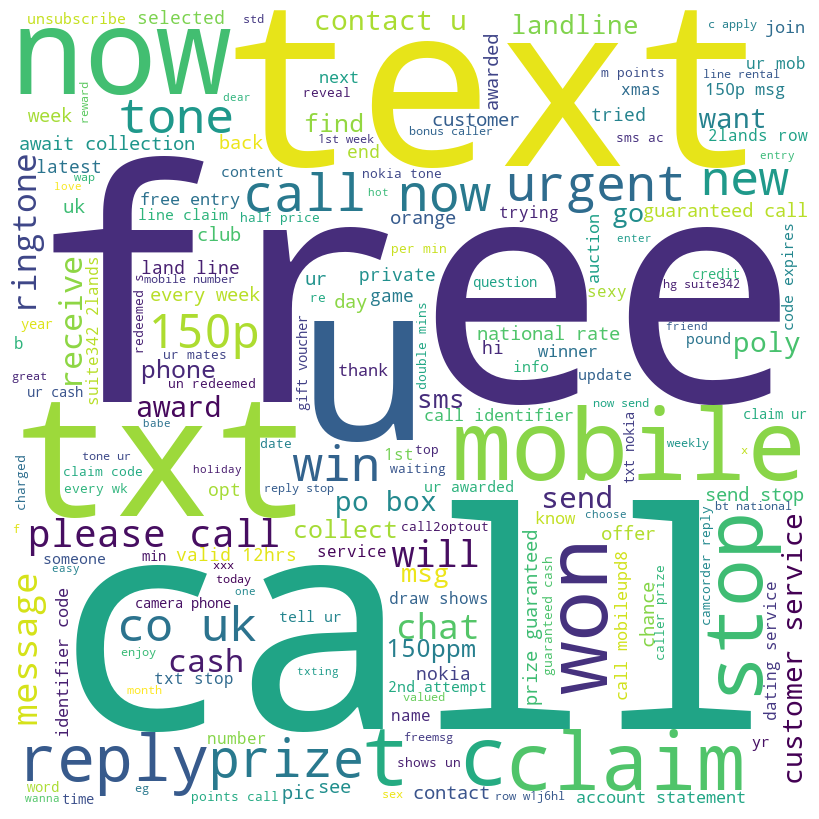

In [94]:
display_wordcloud_spam_text()

In [97]:
df.head()

,label,message,Topic-1,Topic-2
0,ham,"Go until jurong point, crazy.. Available only ...",0.056750,-0.013035
1,ham,Ok lar... Joking wif u oni...,0.190607,0.250928
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,0.051768,-0.016586
3,ham,U dun say so early hor... U c already then say...,0.057829,-0.011530
4,ham,"Nah I don't think he goes to usf, he lives aro...",0.036736,-0.012663


## Plot the encoding

In [109]:
plt.figure(figsize=(15,6))
temp = df.query('label=="ham"')
plt.scatter(temp['Topic-1'], temp['Topic-2'], c='seagreen', label='HAM', alpha=0.5)

temp = df.query('label=="spam"')
plt.scatter(temp['Topic-1'], temp['Topic-2'], c='salmon', label='SPAM', alpha=0.5)

plt.xlabel('Topic - 2')
plt.ylabel('Topic - 1')
plt.legend()

<img src='./plots/Ham-vs-Spam-tfidf-NLTK-processing.png'>

In [110]:
plt.figure(figsize=(15,6))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6), constrained_layout=True, sharey=True)

temp = df.query('label=="ham"')
ax[0].scatter(temp['Topic-1'], temp['Topic-2'], c='seagreen', label='HAM', alpha=0.5)

temp = df.query('label=="spam"')
ax[1].scatter(temp['Topic-1'], temp['Topic-2'], c='salmon', label='SPAM', alpha=0.5);

<img src='./plots/Ham-vs-Spam-tfidf-NLTK-processing-seperate-plots.png'>